In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys

if "../" not in sys.path:
    sys.path.append("../")
    print("[sys.path]:", sys.path)

In [7]:
from src.data.babel import BabelDataset

In [ ]:
train_dataset = BabelDataset(
    split="train",
    pipeline="locate"
)
validation_dataset = BabelDataset(
    split="validation",
    pipeline="locate"
)

In [9]:
print("[#train_dataset]:", len(train_dataset))
print("[#validation_dataset]:", len(validation_dataset))

[#train_dataset]: 3296
[#validation_dataset]: 1129


In [10]:
import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict

from src.constants import (
    DEFAULT_FPS
)

In [11]:
plt.style.use('default')
sns.set_palette("husl")

In [12]:
def analyze_prompts(dataset, dataset_name="Dataset"):
    all_prompts = []
    sample_prompt_counts = []
    source_counts = Counter()
    is_sequence_counts = Counter()
    durations = []
    sequence_durations = []
    frame_durations = []
    spans_per_prompt = defaultdict(list)
    
    motion_lengths_frames = []
    motion_lengths_seconds = []
    spans_per_motion = []
    spans_durations_per_motion = []
    
    for i, sample in enumerate(tqdm.tqdm(dataset)):
        prompts_list = sample.get("prompts", [])
        sample_prompt_counts.append(len(prompts_list))
        
        motion = sample.get("motion", {})
        if isinstance(motion, dict) and "new_joint_vecs" in motion:
            motion_length = len(motion["new_joint_vecs"])
            motion_lengths_frames.append(motion_length)
            motion_lengths_seconds.append(motion_length / DEFAULT_FPS)
        
        motion_spans = []
        motion_spans_durations = []
        
        for prompt_data in prompts_list:
            prompt_text = prompt_data.get("text", "")
            span = prompt_data.get("span", [])
            source = prompt_data.get("source", "unknown")
            is_sequence = prompt_data.get("is_sequence", True)
            
            all_prompts.append(prompt_text)
            source_counts[source] += 1
            is_sequence_counts[is_sequence] += 1
            
            if len(span) == 2:
                duration_frames = span[1] - span[0]
                durations.append(duration_frames)
                spans_per_prompt[prompt_text].append(span)
                motion_spans.append(span)
                motion_spans_durations.append(duration_frames)
                
                if is_sequence:
                    sequence_durations.append(duration_frames)
                else:
                    frame_durations.append(duration_frames)
        
        spans_per_motion.append(len(motion_spans))
        spans_durations_per_motion.append(sum(motion_spans_durations) if motion_spans_durations else 0)
    
    return {
        'all_prompts': all_prompts,
        'sample_prompt_counts': sample_prompt_counts,
        'source_counts': source_counts,
        'is_sequence_counts': is_sequence_counts,
        'durations': durations,
        'sequence_durations': sequence_durations,
        'frame_durations': frame_durations,
        'spans_per_prompt': spans_per_prompt,
        'dataset_name': dataset_name,
        'motion_lengths_frames': motion_lengths_frames,
        'motion_lengths_seconds': motion_lengths_seconds,
        'spans_per_motion': spans_per_motion,
        'spans_durations_per_motion': spans_durations_per_motion
    }

In [13]:
train_analysis = analyze_prompts(train_dataset, "Train")
validation_analysis = analyze_prompts(validation_dataset, "Validation")

100%|██████████| 1129/1129 [00:47<00:00, 23.75it/s]


In [14]:
print("=== BASIC STATISTICS ===")
print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(validation_dataset)} samples")
print()

for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    print(f"{name} Dataset:")
    print(f"  Total prompts: {len(analysis['all_prompts'])}")
    print(f"  Unique prompts: {len(set(analysis['all_prompts']))}")
    print(f"  Avg prompts per sample: {np.mean(analysis['sample_prompt_counts']):.2f}")
    print(f"  Min prompts per sample: {np.min(analysis['sample_prompt_counts'])}")
    print(f"  Max prompts per sample: {np.max(analysis['sample_prompt_counts'])}")
    print()
    
    print(f"  Source distribution:")
    for source, count in analysis['source_counts'].items():
        print(f"    {source}: {count} ({count/len(analysis['all_prompts'])*100:.1f}%)")
    print()
    
    print(f"  Sequence vs Frame annotations:")
    for is_seq, count in analysis['is_sequence_counts'].items():
        label = "Sequence" if is_seq else "Frame"
        print(f"    {label}: {count} ({count/len(analysis['all_prompts'])*100:.1f}%)")
    print()
    
    if analysis['durations']:
        print(f"  Duration statistics (frames):")
        print(f"    Min: {np.min(analysis['durations'])} frames ({np.min(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Mean: {np.mean(analysis['durations']):.2f} frames ({np.mean(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Max: {np.max(analysis['durations'])} frames ({np.max(analysis['durations'])/DEFAULT_FPS:.2f}s)")
        print(f"    Std: {np.std(analysis['durations']):.2f} frames ({np.std(analysis['durations'])/DEFAULT_FPS:.2f}s)")
    print("-" * 50)

=== BASIC STATISTICS ===
Train Dataset: 3296 samples
Validation Dataset: 1129 samples

Train Dataset:
  Total prompts: 10018
  Unique prompts: 28
  Avg prompts per sample: 3.04
  Min prompts per sample: 1
  Max prompts per sample: 28

  Source distribution:
    act_cat: 10018 (100.0%)

  Sequence vs Frame annotations:
    Frame: 9839 (98.2%)
    Sequence: 179 (1.8%)

  Duration statistics (frames):
    Min: 1 frames (0.05s)
    Mean: 18.43 frames (0.92s)
    Max: 32 frames (1.60s)
    Std: 7.93 frames (0.40s)
--------------------------------------------------
Validation Dataset:
  Total prompts: 3662
  Unique prompts: 28
  Avg prompts per sample: 3.24
  Min prompts per sample: 1
  Max prompts per sample: 25

  Source distribution:
    act_cat: 3662 (100.0%)

  Sequence vs Frame annotations:
    Frame: 3612 (98.6%)
    Sequence: 50 (1.4%)

  Duration statistics (frames):
    Min: 1 frames (0.05s)
    Mean: 17.95 frames (0.90s)
    Max: 32 frames (1.60s)
    Std: 8.19 frames (0.41s)
----

<div class="alert alert-info">

#### **Number of Motions**

This shows the total number of motion sequences in each dataset split.

</div>

=== NUMBER OF MOTIONS ===
Train Dataset: 3296 motions
Validation Dataset: 1129 motions


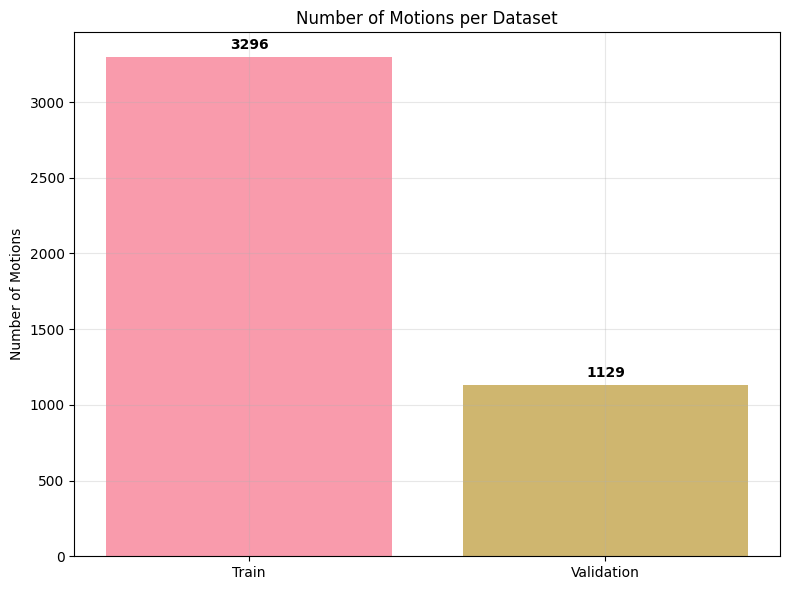

In [15]:
print("=== NUMBER OF MOTIONS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    num_motions = len(analysis['motion_lengths_frames'])
    print(f"{name} Dataset: {num_motions} motions")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
datasets = ['Train', 'Validation']
motion_counts = [len(train_analysis['motion_lengths_frames']), len(validation_analysis['motion_lengths_frames'])]
colors = ['C0', 'C1']

bars = ax.bar(datasets, motion_counts, color=colors, alpha=0.7)
ax.set_title('Number of Motions per Dataset')
ax.set_ylabel('Number of Motions')
ax.grid(True, alpha=0.3)

for bar, count in zip(bars, motion_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(motion_counts)*0.01, 
            str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

<div class="alert alert-info">

#### **Motion Length Distribution**

This shows the distribution of motion sequence lengths in both frames and seconds, with horizontal lines indicating minimum, maximum, and average values.

</div>

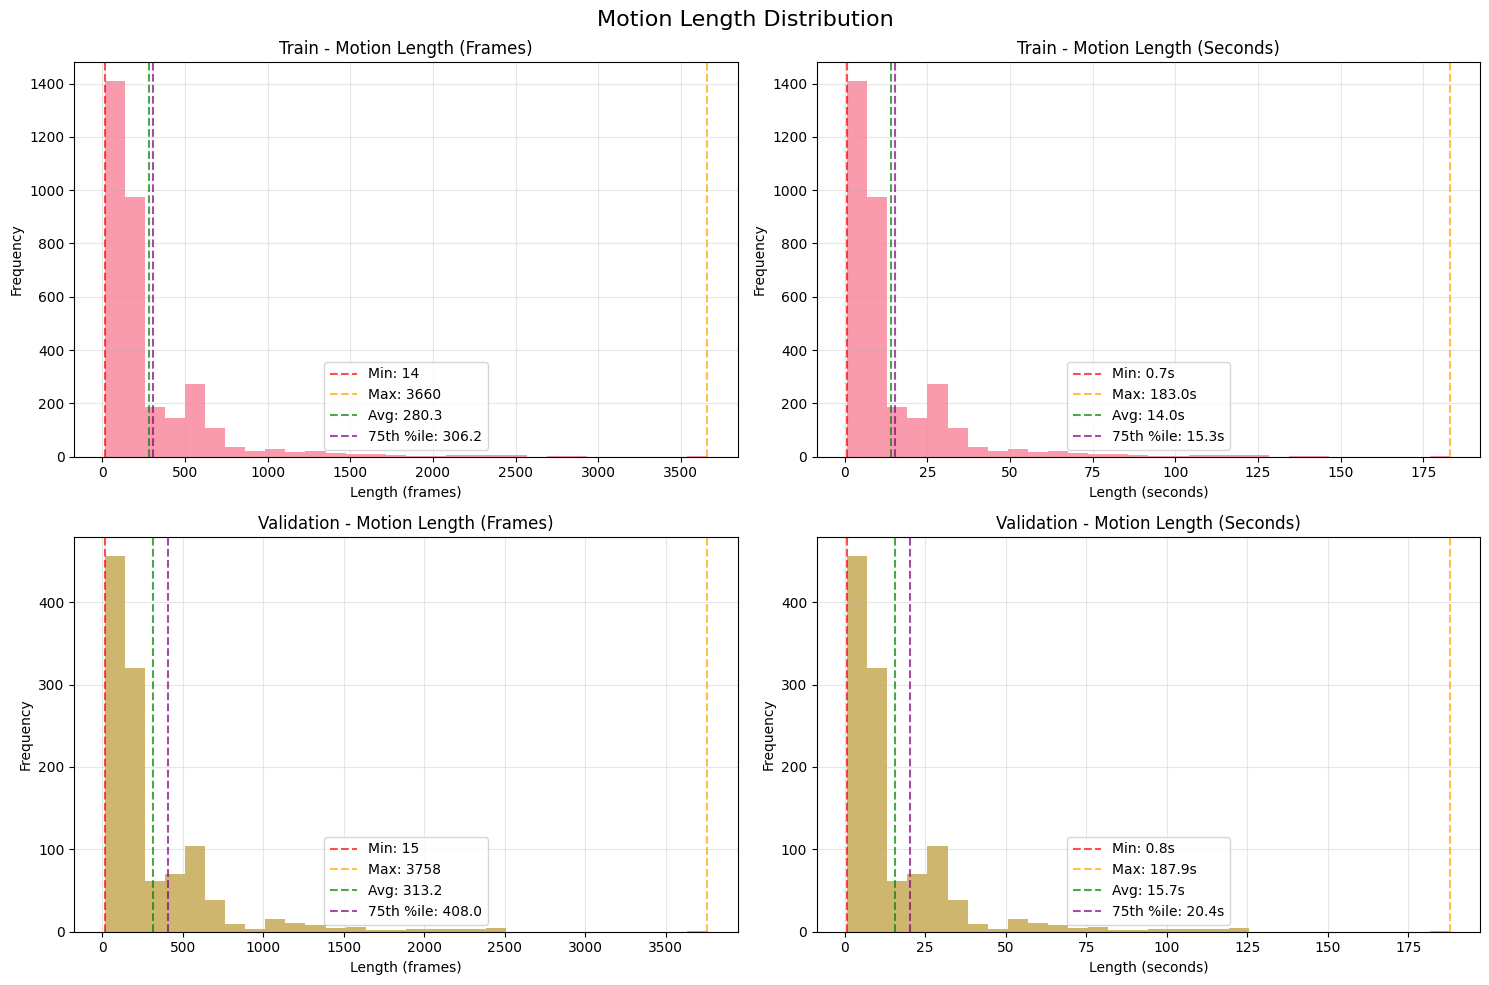

=== MOTION LENGTH STATISTICS ===

Train Dataset:
  Frames - Min: 14, Mean: 280.29, Max: 3660
  Seconds - Min: 0.70, Mean: 14.01, Max: 183.00
  75th percentile - Frames: 306.25, Seconds: 15.31
  Data loss if filtering > 10s (200 frames): 1143 samples (34.7%)
  Data loss if filtering > 15s (300 frames): 834 samples (25.3%)
  Data loss if filtering > 20s (400 frames): 708 samples (21.5%)
--------------------------------------------------

Validation Dataset:
  Frames - Min: 15, Mean: 313.18, Max: 3758
  Seconds - Min: 0.75, Mean: 15.66, Max: 187.90
  75th percentile - Frames: 408.00, Seconds: 20.40
  Data loss if filtering > 10s (200 frames): 430 samples (38.1%)
  Data loss if filtering > 15s (300 frames): 330 samples (29.2%)
  Data loss if filtering > 20s (400 frames): 287 samples (25.4%)
--------------------------------------------------


In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Motion Length Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    lengths_frames = analysis['motion_lengths_frames']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_frames:
        # NOTE: frames distribution
        axes[i, 0].hist(lengths_frames, bins=30, alpha=0.7, color=f'C{i}')
        axes[i, 0].set_title(f'{name} - Motion Length (Frames)')
        axes[i, 0].set_xlabel('Length (frames)')
        axes[i, 0].set_ylabel('Frequency')
        axes[i, 0].grid(True, alpha=0.3)
        
        min_frames = np.min(lengths_frames)
        max_frames = np.max(lengths_frames)
        avg_frames = np.mean(lengths_frames)
        p75_frames = np.percentile(lengths_frames, 75)
        
        axes[i, 0].axvline(min_frames, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_frames}')
        axes[i, 0].axvline(max_frames, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_frames}')
        axes[i, 0].axvline(avg_frames, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_frames:.1f}')
        axes[i, 0].axvline(p75_frames, color='purple', linestyle='--', alpha=0.7, label=f'75th %ile: {p75_frames:.1f}')
        axes[i, 0].legend()
        
        # NOTE: seconds distribution
        axes[i, 1].hist(lengths_seconds, bins=30, alpha=0.7, color=f'C{i}')
        axes[i, 1].set_title(f'{name} - Motion Length (Seconds)')
        axes[i, 1].set_xlabel('Length (seconds)')
        axes[i, 1].set_ylabel('Frequency')
        axes[i, 1].grid(True, alpha=0.3)
        
        min_seconds = np.min(lengths_seconds)
        max_seconds = np.max(lengths_seconds)
        avg_seconds = np.mean(lengths_seconds)
        p75_seconds = np.percentile(lengths_seconds, 75)
        
        axes[i, 1].axvline(min_seconds, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_seconds:.1f}s')
        axes[i, 1].axvline(max_seconds, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_seconds:.1f}s')
        axes[i, 1].axvline(avg_seconds, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_seconds:.1f}s')
        axes[i, 1].axvline(p75_seconds, color='purple', linestyle='--', alpha=0.7, label=f'75th %ile: {p75_seconds:.1f}s')
        axes[i, 1].legend()

plt.tight_layout()
plt.show()

print("=== MOTION LENGTH STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    lengths_frames = analysis['motion_lengths_frames']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_frames:
        print(f"\n{name} Dataset:")
        print(f"  Frames - Min: {np.min(lengths_frames)}, Mean: {np.mean(lengths_frames):.2f}, Max: {np.max(lengths_frames)}")
        print(f"  Seconds - Min: {np.min(lengths_seconds):.2f}, Mean: {np.mean(lengths_seconds):.2f}, Max: {np.max(lengths_seconds):.2f}")
        print(f"  75th percentile - Frames: {np.percentile(lengths_frames, 75):.2f}, Seconds: {np.percentile(lengths_seconds, 75):.2f}")
        
        for threshold_sec in [10, 15, 20]:
            threshold_frames = threshold_sec * DEFAULT_FPS
            filtered_count = np.sum(np.array(lengths_frames) > threshold_frames)
            loss_percentage = (filtered_count / len(lengths_frames)) * 100
            print(f"  Data loss if filtering > {threshold_sec}s ({threshold_frames} frames): {filtered_count} samples ({loss_percentage:.1f}%)")
    print("-" * 50)

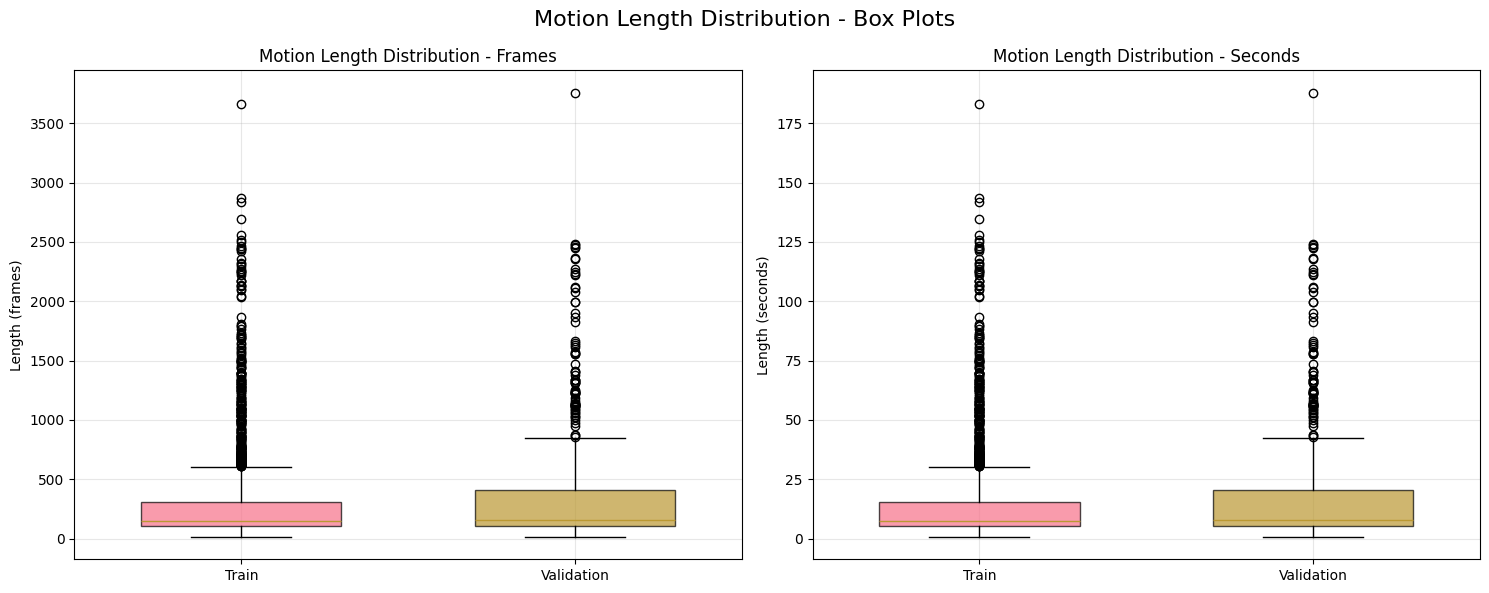

=== MOTION LENGTH FILTERING ANALYSIS ===

Train Dataset (3296 total motions):
  Motions < 2s: 189 (5.7%)
  Motions < 3s: 240 (7.3%)
  Motions < 5s: 728 (22.1%)
  Motions > 10s: 1143 (34.7%)
  Motions > 15s: 834 (25.3%)
  Motions > 20s: 708 (21.5%)
  Motions > 25s: 579 (17.6%)
  Keeping 3s-15s: 2222 motions (67.4% retained)
  Keeping 3s-20s: 2348 motions (71.2% retained)
  Keeping 5s-20s: 1860 motions (56.4% retained)
--------------------------------------------------

Validation Dataset (1129 total motions):
  Motions < 2s: 55 (4.9%)
  Motions < 3s: 77 (6.8%)
  Motions < 5s: 221 (19.6%)
  Motions > 10s: 430 (38.1%)
  Motions > 15s: 330 (29.2%)
  Motions > 20s: 287 (25.4%)
  Motions > 25s: 224 (19.8%)
  Keeping 3s-15s: 722 motions (64.0% retained)
  Keeping 3s-20s: 765 motions (67.8% retained)
  Keeping 5s-20s: 621 motions (55.0% retained)
--------------------------------------------------


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Motion Length Distribution - Box Plots', fontsize=16)

datasets = ['Train', 'Validation']
for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    lengths_frames = analysis['motion_lengths_frames']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_frames:
        box_data_frames = [lengths_frames]
        bp1 = axes[0].boxplot(box_data_frames, positions=[i+1], widths=0.6, patch_artist=True)
        bp1['boxes'][0].set_facecolor(f'C{i}')
        bp1['boxes'][0].set_alpha(0.7)
        
        box_data_seconds = [lengths_seconds]
        bp2 = axes[1].boxplot(box_data_seconds, positions=[i+1], widths=0.6, patch_artist=True)
        bp2['boxes'][0].set_facecolor(f'C{i}')
        bp2['boxes'][0].set_alpha(0.7)

axes[0].set_title('Motion Length Distribution - Frames')
axes[0].set_ylabel('Length (frames)')
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(datasets)
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Motion Length Distribution - Seconds')
axes[1].set_ylabel('Length (seconds)')
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(datasets)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== MOTION LENGTH FILTERING ANALYSIS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    lengths_seconds = analysis['motion_lengths_seconds']
    
    if lengths_seconds:
        total_motions = len(lengths_seconds)
        print(f"\n{name} Dataset ({total_motions} total motions):")
        
        for min_threshold in [2, 3, 5]:
            filtered_min = np.sum(np.array(lengths_seconds) < min_threshold)
            print(f"  Motions < {min_threshold}s: {filtered_min} ({filtered_min/total_motions*100:.1f}%)")
            
        for max_threshold in [10, 15, 20, 25]:
            filtered_max = np.sum(np.array(lengths_seconds) > max_threshold)
            print(f"  Motions > {max_threshold}s: {filtered_max} ({filtered_max/total_motions*100:.1f}%)")
            
        for min_t, max_t in [(3, 15), (3, 20), (5, 20)]:
            filtered_both = np.sum((np.array(lengths_seconds) < min_t) | (np.array(lengths_seconds) > max_t))
            remaining = total_motions - filtered_both
            print(f"  Keeping {min_t}s-{max_t}s: {remaining} motions ({remaining/total_motions*100:.1f}% retained)")
    print("-" * 50)

<div class="alert alert-info">

#### **Prompts per Motion Distribution**

This shows how many prompts are associated with each motion sequence, with horizontal lines indicating minimum, maximum, and average values.

</div>

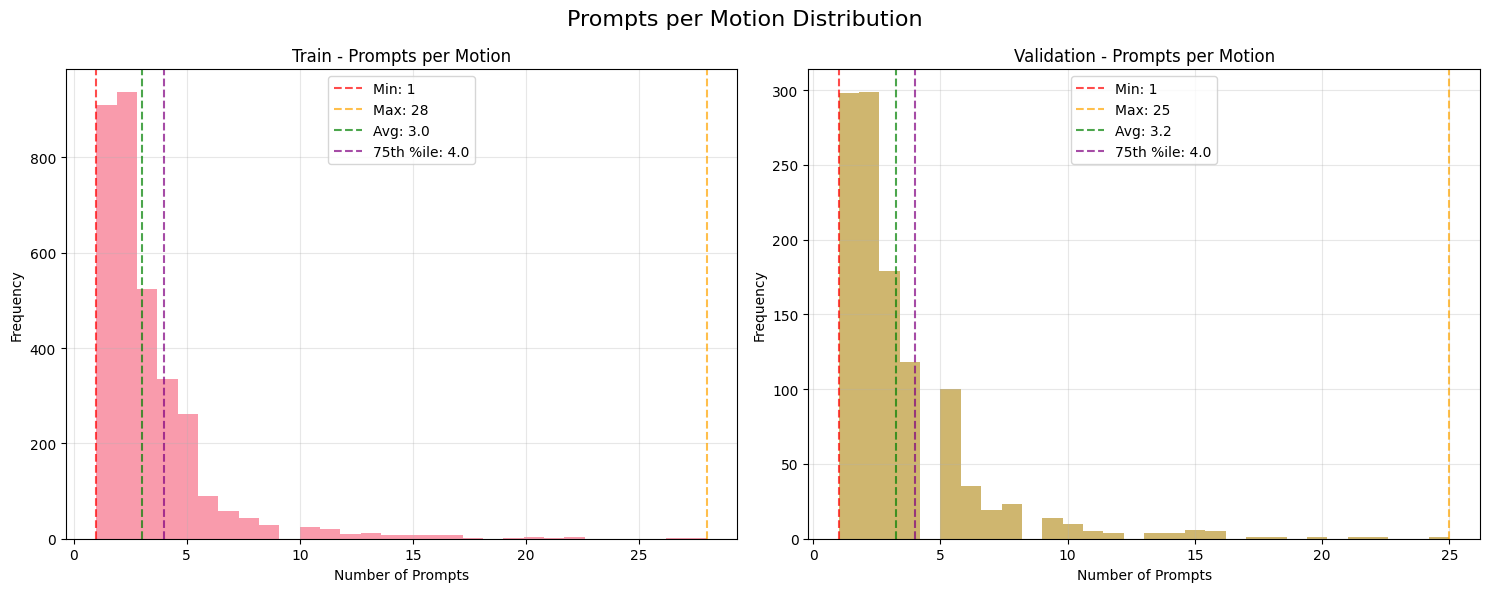

=== PROMPTS PER MOTION STATISTICS ===

Train Dataset:
  Min: 1, Mean: 3.04, Max: 28
  75th percentile: 4.00
  Data loss if filtering > 12 prompts: 54 samples (1.6%)
  Data loss if filtering > 15 prompts: 29 samples (0.9%)
  Data loss if filtering > 20 prompts: 7 samples (0.2%)
--------------------------------------------------

Validation Dataset:
  Min: 1, Mean: 3.24, Max: 25
  75th percentile: 4.00
  Data loss if filtering > 12 prompts: 25 samples (2.2%)
  Data loss if filtering > 15 prompts: 11 samples (1.0%)
  Data loss if filtering > 20 prompts: 3 samples (0.3%)
--------------------------------------------------


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Prompts per Motion Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    prompts_per_motion = analysis['sample_prompt_counts']
    
    if prompts_per_motion:
        axes[i].hist(prompts_per_motion, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Prompts per Motion')
        axes[i].set_xlabel('Number of Prompts')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        min_prompts = np.min(prompts_per_motion)
        max_prompts = np.max(prompts_per_motion)
        avg_prompts = np.mean(prompts_per_motion)
        p75_prompts = np.percentile(prompts_per_motion, 75)
        
        axes[i].axvline(min_prompts, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_prompts}')
        axes[i].axvline(max_prompts, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_prompts}')
        axes[i].axvline(avg_prompts, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_prompts:.1f}')
        axes[i].axvline(p75_prompts, color='purple', linestyle='--', alpha=0.7, label=f'75th %ile: {p75_prompts:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== PROMPTS PER MOTION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    prompts_per_motion = analysis['sample_prompt_counts']
    
    if prompts_per_motion:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(prompts_per_motion)}, Mean: {np.mean(prompts_per_motion):.2f}, Max: {np.max(prompts_per_motion)}")
        print(f"  75th percentile: {np.percentile(prompts_per_motion, 75):.2f}")
        
        for threshold in [12, 15, 20]:
            filtered_count = np.sum(np.array(prompts_per_motion) > threshold)
            loss_percentage = (filtered_count / len(prompts_per_motion)) * 100
            print(f"  Data loss if filtering > {threshold} prompts: {filtered_count} samples ({loss_percentage:.1f}%)")
    print("-" * 50)

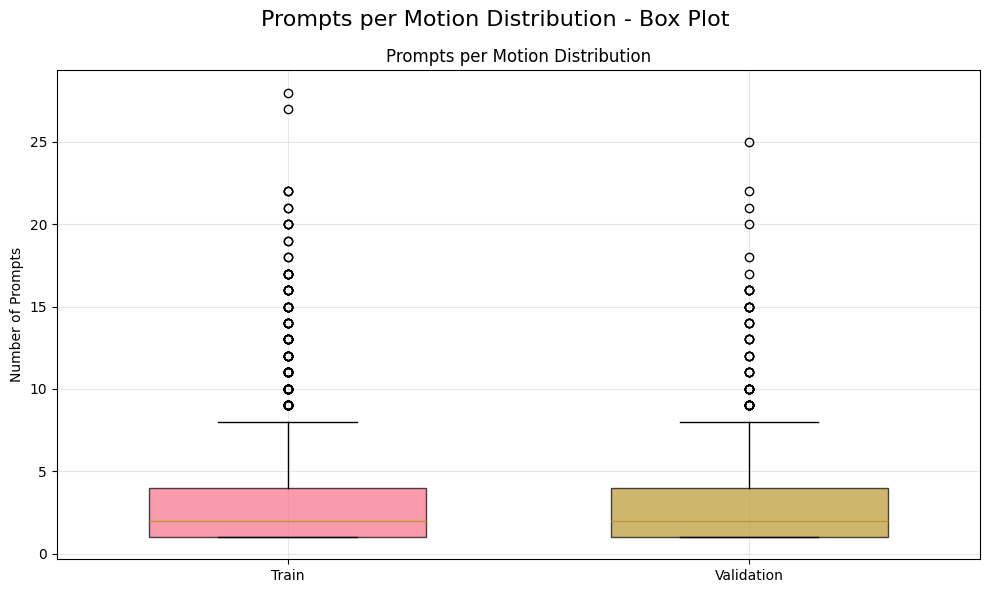

=== PROMPTS PER MOTION FILTERING ANALYSIS ===

Train Dataset (3296 total motions):
  Motions < 1 prompts: 0 (0.0%)
  Motions < 2 prompts: 911 (27.6%)
  Motions < 3 prompts: 1849 (56.1%)
  Motions < 5 prompts: 2707 (82.1%)
  Motions > 8 prompts: 135 (4.1%)
  Motions > 10 prompts: 83 (2.5%)
  Motions > 12 prompts: 54 (1.6%)
  Motions > 15 prompts: 29 (0.9%)
  Motions > 20 prompts: 7 (0.2%)
  Keeping 2-8 prompts: 2250 motions (68.3% retained)
  Keeping 2-10 prompts: 2302 motions (69.8% retained)
  Keeping 3-12 prompts: 1393 motions (42.3% retained)
--------------------------------------------------

Validation Dataset (1129 total motions):
  Motions < 1 prompts: 0 (0.0%)
  Motions < 2 prompts: 298 (26.4%)
  Motions < 3 prompts: 597 (52.9%)
  Motions < 5 prompts: 894 (79.2%)
  Motions > 8 prompts: 58 (5.1%)
  Motions > 10 prompts: 34 (3.0%)
  Motions > 12 prompts: 25 (2.2%)
  Motions > 15 prompts: 11 (1.0%)
  Motions > 20 prompts: 3 (0.3%)
  Keeping 2-8 prompts: 773 motions (68.5% retained

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Prompts per Motion Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    prompts_per_motion = analysis['sample_prompt_counts']
    if prompts_per_motion:
        box_data.append(prompts_per_motion)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Prompts per Motion Distribution')
ax.set_ylabel('Number of Prompts')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== PROMPTS PER MOTION FILTERING ANALYSIS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    prompts_per_motion = analysis['sample_prompt_counts']
    
    if prompts_per_motion:
        total_motions = len(prompts_per_motion)
        print(f"\n{name} Dataset ({total_motions} total motions):")
        
        for min_threshold in [1, 2, 3, 5]:
            filtered_min = np.sum(np.array(prompts_per_motion) < min_threshold)
            print(f"  Motions < {min_threshold} prompts: {filtered_min} ({filtered_min/total_motions*100:.1f}%)")
            
        for max_threshold in [8, 10, 12, 15, 20]:
            filtered_max = np.sum(np.array(prompts_per_motion) > max_threshold)
            print(f"  Motions > {max_threshold} prompts: {filtered_max} ({filtered_max/total_motions*100:.1f}%)")
            
        for min_t, max_t in [(2, 8), (2, 10), (3, 12)]:
            filtered_both = np.sum((np.array(prompts_per_motion) < min_t) | (np.array(prompts_per_motion) > max_t))
            remaining = total_motions - filtered_both
            print(f"  Keeping {min_t}-{max_t} prompts: {remaining} motions ({remaining/total_motions*100:.1f}% retained)")
    print("-" * 50)

<div class="alert alert-info">

#### **Spans per Motion Distribution**

This shows how many spans (temporal segments) are associated with each motion sequence, with horizontal lines indicating minimum, maximum, and average values.

</div>

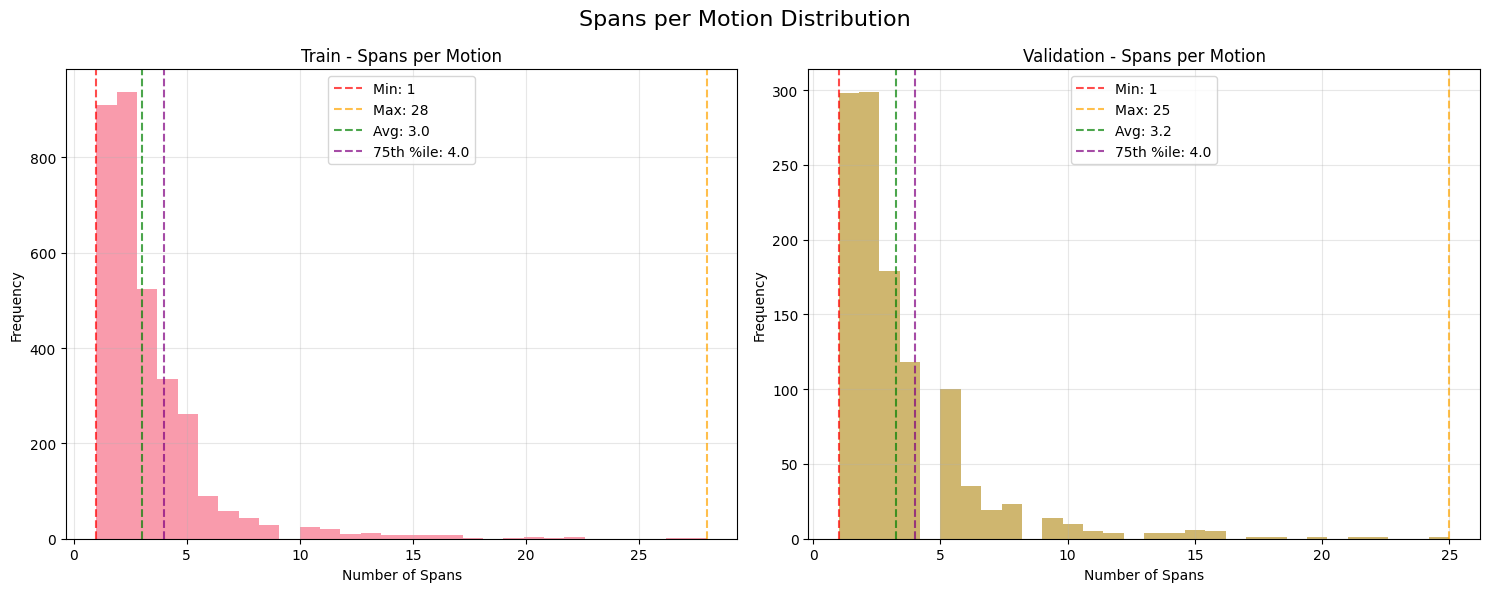

=== SPANS PER MOTION STATISTICS ===

Train Dataset:
  Min: 1, Mean: 3.04, Max: 28
  75th percentile: 4.00
  Data loss if filtering > 10 spans: 83 samples (2.5%)
  Data loss if filtering > 15 spans: 29 samples (0.9%)
  Data loss if filtering > 20 spans: 7 samples (0.2%)
--------------------------------------------------

Validation Dataset:
  Min: 1, Mean: 3.24, Max: 25
  75th percentile: 4.00
  Data loss if filtering > 10 spans: 34 samples (3.0%)
  Data loss if filtering > 15 spans: 11 samples (1.0%)
  Data loss if filtering > 20 spans: 3 samples (0.3%)
--------------------------------------------------


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Spans per Motion Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    spans_per_motion = analysis['spans_per_motion']
    
    if spans_per_motion:
        axes[i].hist(spans_per_motion, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Spans per Motion')
        axes[i].set_xlabel('Number of Spans')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        min_spans = np.min(spans_per_motion)
        max_spans = np.max(spans_per_motion)
        avg_spans = np.mean(spans_per_motion)
        p75_spans = np.percentile(spans_per_motion, 75)
        
        axes[i].axvline(min_spans, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_spans}')
        axes[i].axvline(max_spans, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_spans}')
        axes[i].axvline(avg_spans, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_spans:.1f}')
        axes[i].axvline(p75_spans, color='purple', linestyle='--', alpha=0.7, label=f'75th %ile: {p75_spans:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== SPANS PER MOTION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    spans_per_motion = analysis['spans_per_motion']
    
    if spans_per_motion:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(spans_per_motion)}, Mean: {np.mean(spans_per_motion):.2f}, Max: {np.max(spans_per_motion)}")
        print(f"  75th percentile: {np.percentile(spans_per_motion, 75):.2f}")
        
        for threshold in [10, 15, 20]:
            filtered_count = np.sum(np.array(spans_per_motion) > threshold)
            loss_percentage = (filtered_count / len(spans_per_motion)) * 100
            print(f"  Data loss if filtering > {threshold} spans: {filtered_count} samples ({loss_percentage:.1f}%)")
    print("-" * 50)

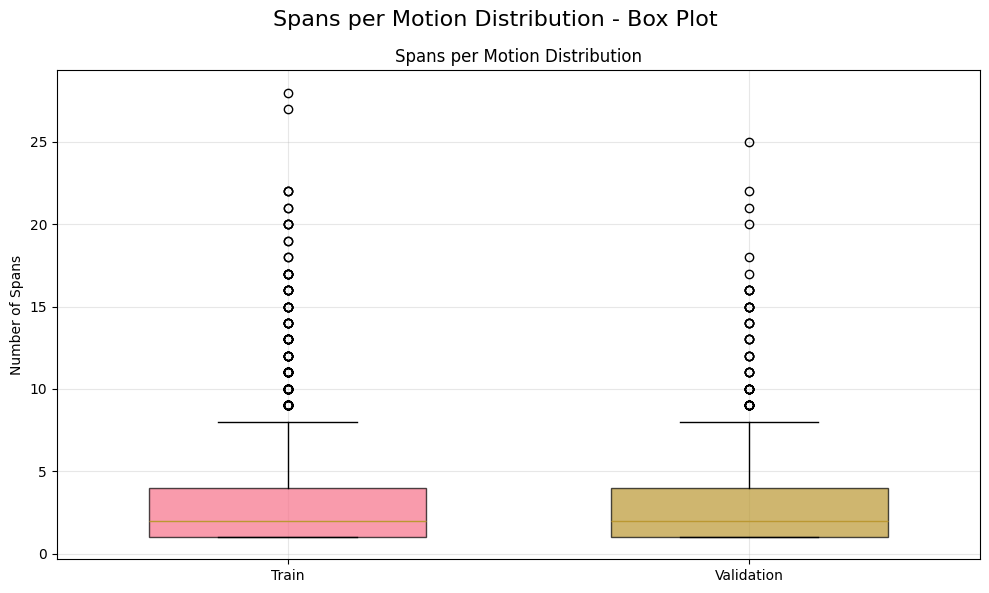

=== SPANS PER MOTION FILTERING ANALYSIS ===

Train Dataset (3296 total motions):
  Motions < 1 spans: 0 (0.0%)
  Motions < 2 spans: 911 (27.6%)
  Motions < 3 spans: 1849 (56.1%)
  Motions < 5 spans: 2707 (82.1%)
  Motions > 8 spans: 135 (4.1%)
  Motions > 10 spans: 83 (2.5%)
  Motions > 12 spans: 54 (1.6%)
  Motions > 15 spans: 29 (0.9%)
  Motions > 20 spans: 7 (0.2%)
  Keeping 2-8 spans: 2250 motions (68.3% retained)
  Keeping 2-10 spans: 2302 motions (69.8% retained)
  Keeping 3-12 spans: 1393 motions (42.3% retained)
--------------------------------------------------

Validation Dataset (1129 total motions):
  Motions < 1 spans: 0 (0.0%)
  Motions < 2 spans: 298 (26.4%)
  Motions < 3 spans: 597 (52.9%)
  Motions < 5 spans: 894 (79.2%)
  Motions > 8 spans: 58 (5.1%)
  Motions > 10 spans: 34 (3.0%)
  Motions > 12 spans: 25 (2.2%)
  Motions > 15 spans: 11 (1.0%)
  Motions > 20 spans: 3 (0.3%)
  Keeping 2-8 spans: 773 motions (68.5% retained)
  Keeping 2-10 spans: 797 motions (70.6% ret

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Spans per Motion Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    spans_per_motion = analysis['spans_per_motion']
    if spans_per_motion:
        box_data.append(spans_per_motion)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Spans per Motion Distribution')
ax.set_ylabel('Number of Spans')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== SPANS PER MOTION FILTERING ANALYSIS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    spans_per_motion = analysis['spans_per_motion']
    
    if spans_per_motion:
        total_motions = len(spans_per_motion)
        print(f"\n{name} Dataset ({total_motions} total motions):")
        
        for min_threshold in [1, 2, 3, 5]:
            filtered_min = np.sum(np.array(spans_per_motion) < min_threshold)
            print(f"  Motions < {min_threshold} spans: {filtered_min} ({filtered_min/total_motions*100:.1f}%)")
            
        for max_threshold in [8, 10, 12, 15, 20]:
            filtered_max = np.sum(np.array(spans_per_motion) > max_threshold)
            print(f"  Motions > {max_threshold} spans: {filtered_max} ({filtered_max/total_motions*100:.1f}%)")
            
        for min_t, max_t in [(2, 8), (2, 10), (3, 12)]:
            filtered_both = np.sum((np.array(spans_per_motion) < min_t) | (np.array(spans_per_motion) > max_t))
            remaining = total_motions - filtered_both
            print(f"  Keeping {min_t}-{max_t} spans: {remaining} motions ({remaining/total_motions*100:.1f}% retained)")
    print("-" * 50)

<div class="alert alert-info">

#### **Spans Duration Distribution**

This shows the distribution of individual span durations in frames, with horizontal lines indicating minimum, maximum, and average values.

</div>

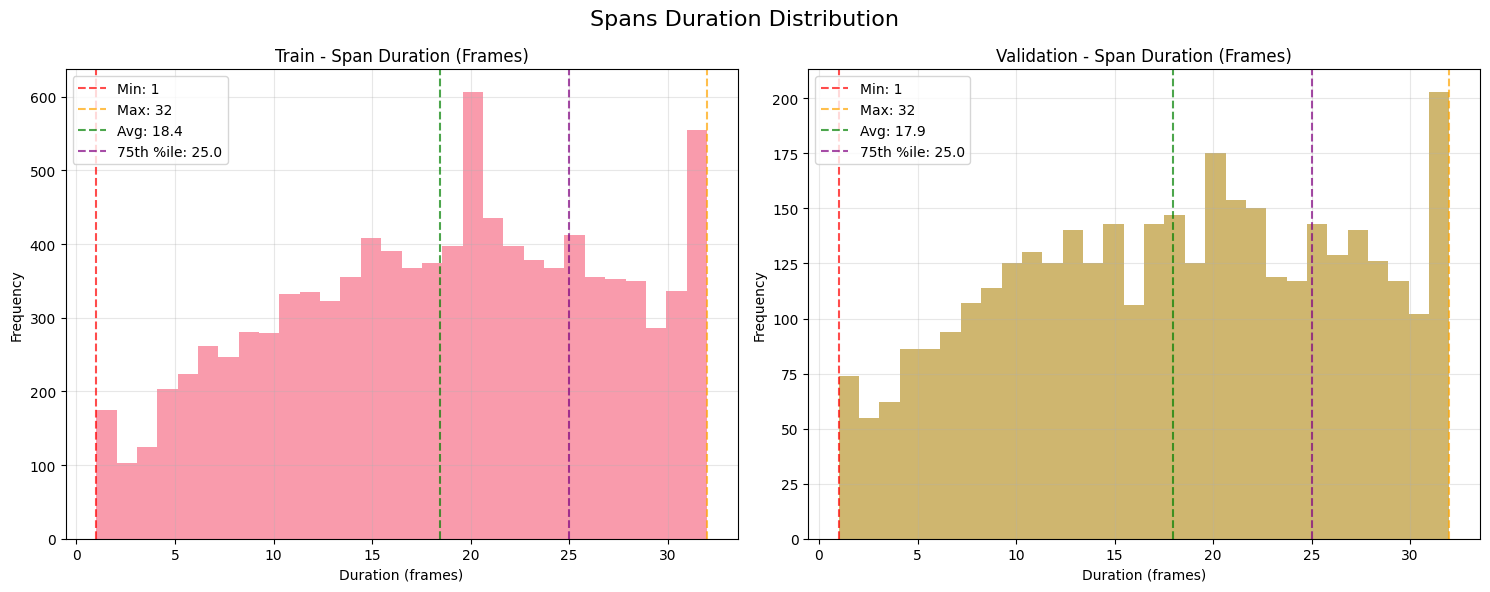

=== SPANS DURATION STATISTICS ===

Train Dataset:
  Min: 1 frames (0.05s)
  Mean: 18.43 frames (0.92s)
  Max: 32 frames (1.60s)
  75th percentile: 25.00 frames (1.25s)
  Data loss if filtering > 3s (60 frames): 0 spans (0.0%)
  Data loss if filtering > 5s (100 frames): 0 spans (0.0%)
  Data loss if filtering > 8s (160 frames): 0 spans (0.0%)
--------------------------------------------------

Validation Dataset:
  Min: 1 frames (0.05s)
  Mean: 17.95 frames (0.90s)
  Max: 32 frames (1.60s)
  75th percentile: 25.00 frames (1.25s)
  Data loss if filtering > 3s (60 frames): 0 spans (0.0%)
  Data loss if filtering > 5s (100 frames): 0 spans (0.0%)
  Data loss if filtering > 8s (160 frames): 0 spans (0.0%)
--------------------------------------------------


In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Spans Duration Distribution', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    span_durations = analysis['durations']
    
    if span_durations:
        axes[i].hist(span_durations, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Span Duration (Frames)')
        axes[i].set_xlabel('Duration (frames)')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)
        
        min_duration = np.min(span_durations)
        max_duration = np.max(span_durations)
        avg_duration = np.mean(span_durations)
        p75_duration = np.percentile(span_durations, 75)
        
        axes[i].axvline(min_duration, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_duration}')
        axes[i].axvline(max_duration, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_duration}')
        axes[i].axvline(avg_duration, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_duration:.1f}')
        axes[i].axvline(p75_duration, color='purple', linestyle='--', alpha=0.7, label=f'75th %ile: {p75_duration:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== SPANS DURATION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    span_durations = analysis['durations']
    
    if span_durations:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(span_durations)} frames ({np.min(span_durations)/DEFAULT_FPS:.2f}s)")
        print(f"  Mean: {np.mean(span_durations):.2f} frames ({np.mean(span_durations)/DEFAULT_FPS:.2f}s)")
        print(f"  Max: {np.max(span_durations)} frames ({np.max(span_durations)/DEFAULT_FPS:.2f}s)")
        print(f"  75th percentile: {np.percentile(span_durations, 75):.2f} frames ({np.percentile(span_durations, 75)/DEFAULT_FPS:.2f}s)")
        
        for threshold_sec in [3, 5, 8]:
            threshold_frames = threshold_sec * DEFAULT_FPS
            filtered_count = np.sum(np.array(span_durations) > threshold_frames)
            loss_percentage = (filtered_count / len(span_durations)) * 100
            print(f"  Data loss if filtering > {threshold_sec}s ({threshold_frames} frames): {filtered_count} spans ({loss_percentage:.1f}%)")
    print("-" * 50)

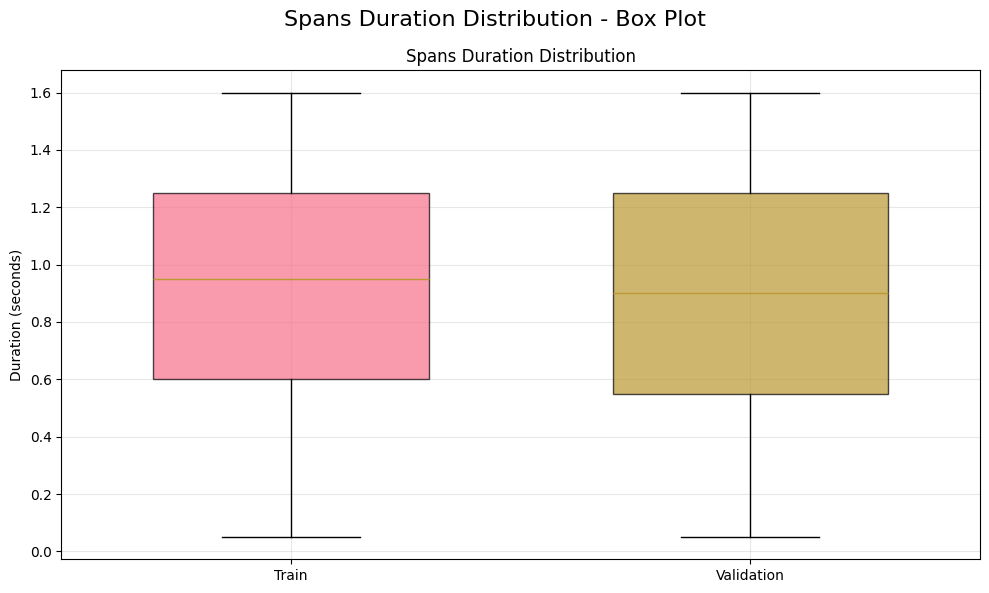

=== SPANS DURATION FILTERING ANALYSIS ===

Train Dataset (10018 total spans):
  Spans < 0.5s: 1619 (16.2%)
  Spans < 1.0s: 5184 (51.7%)
  Spans < 1.5s: 9127 (91.1%)
  Spans < 2.0s: 10018 (100.0%)
  Spans > 3s: 0 (0.0%)
  Spans > 5s: 0 (0.0%)
  Spans > 8s: 0 (0.0%)
  Spans > 10s: 0 (0.0%)
  Keeping 1.0s-5s: 4834 spans (48.3% retained)
  Keeping 1.0s-8s: 4834 spans (48.3% retained)
  Keeping 1.5s-8s: 891 spans (8.9% retained)
--------------------------------------------------

Validation Dataset (3662 total spans):
  Spans < 0.5s: 678 (18.5%)
  Spans < 1.0s: 1987 (54.3%)
  Spans < 1.5s: 3357 (91.7%)
  Spans < 2.0s: 3662 (100.0%)
  Spans > 3s: 0 (0.0%)
  Spans > 5s: 0 (0.0%)
  Spans > 8s: 0 (0.0%)
  Spans > 10s: 0 (0.0%)
  Keeping 1.0s-5s: 1675 spans (45.7% retained)
  Keeping 1.0s-8s: 1675 spans (45.7% retained)
  Keeping 1.5s-8s: 305 spans (8.3% retained)
--------------------------------------------------


In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Spans Duration Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    span_durations = analysis['durations']
    if span_durations:
        span_durations_seconds = [d / DEFAULT_FPS for d in span_durations]
        box_data.append(span_durations_seconds)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Spans Duration Distribution')
ax.set_ylabel('Duration (seconds)')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== SPANS DURATION FILTERING ANALYSIS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    span_durations = analysis['durations']
    
    if span_durations:
        total_spans = len(span_durations)
        span_durations_seconds = [d / DEFAULT_FPS for d in span_durations]
        print(f"\n{name} Dataset ({total_spans} total spans):")
        
        for min_threshold in [0.5, 1.0, 1.5, 2.0]:
            filtered_min = np.sum(np.array(span_durations_seconds) < min_threshold)
            print(f"  Spans < {min_threshold}s: {filtered_min} ({filtered_min/total_spans*100:.1f}%)")
            
        for max_threshold in [3, 5, 8, 10]:
            filtered_max = np.sum(np.array(span_durations_seconds) > max_threshold)
            print(f"  Spans > {max_threshold}s: {filtered_max} ({filtered_max/total_spans*100:.1f}%)")
            
        for min_t, max_t in [(1.0, 5), (1.0, 8), (1.5, 8)]:
            filtered_both = np.sum((np.array(span_durations_seconds) < min_t) | (np.array(span_durations_seconds) > max_t))
            remaining = total_spans - filtered_both
            print(f"  Keeping {min_t}s-{max_t}s: {remaining} spans ({remaining/total_spans*100:.1f}% retained)")
    print("-" * 50)

<div class="alert alert-info">

#### **Total Spans per Motion (Per Motion Analysis)**

This shows the total span duration per motion sequence, indicating how much of each motion is covered by annotated spans.

</div>

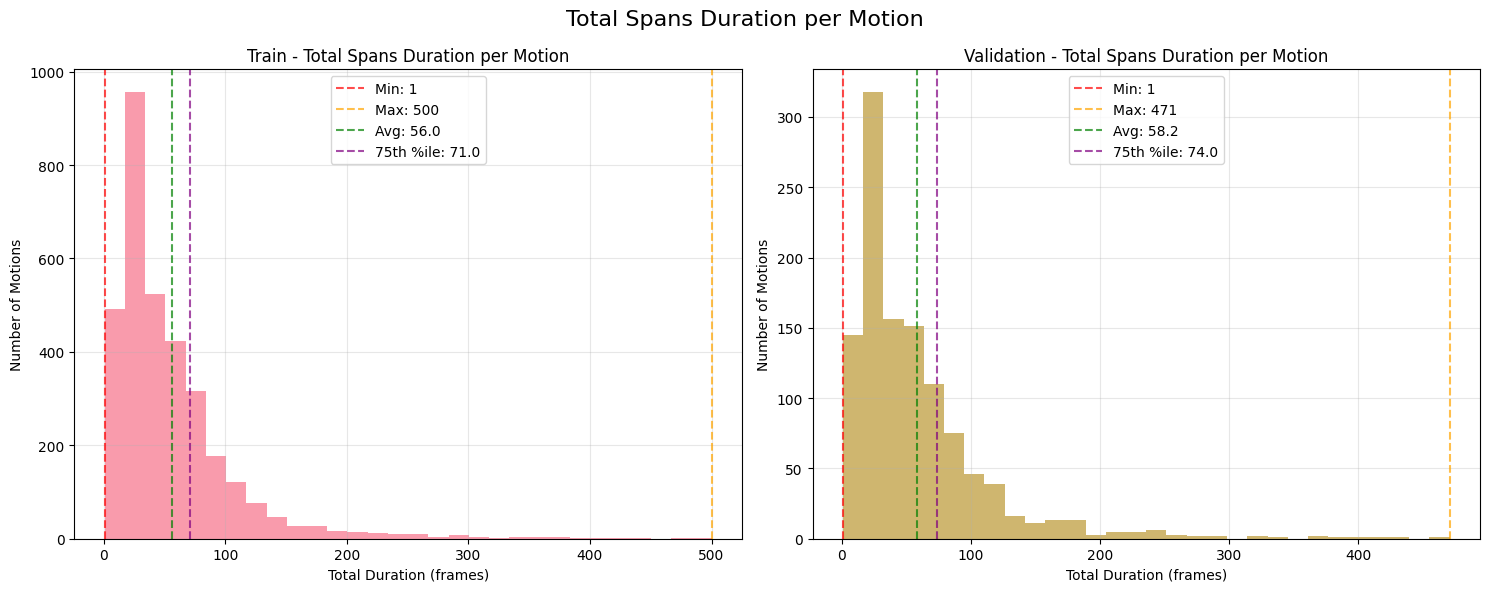

=== TOTAL SPANS DURATION PER MOTION STATISTICS ===

Train Dataset:
  Min: 1 frames (0.05s)
  Mean: 56.03 frames (2.80s)
  Max: 500 frames (25.00s)
  75th percentile: 71.00 frames (3.55s)
  Data loss if filtering > 10s total spans (200 frames): 88 motions (2.7%)
  Data loss if filtering > 15s total spans (300 frames): 29 motions (0.9%)
  Data loss if filtering > 20s total spans (400 frames): 9 motions (0.3%)
--------------------------------------------------

Validation Dataset:
  Min: 1 frames (0.05s)
  Mean: 58.22 frames (2.91s)
  Max: 471 frames (23.55s)
  75th percentile: 74.00 frames (3.70s)
  Data loss if filtering > 10s total spans (200 frames): 34 motions (3.0%)
  Data loss if filtering > 15s total spans (300 frames): 10 motions (0.9%)
  Data loss if filtering > 20s total spans (400 frames): 3 motions (0.3%)
--------------------------------------------------


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Total Spans Duration per Motion', fontsize=16)

for i, analysis in enumerate([train_analysis, validation_analysis]):
    name = analysis['dataset_name']
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    
    if spans_durations_per_motion:
        axes[i].hist(spans_durations_per_motion, bins=30, alpha=0.7, color=f'C{i}')
        axes[i].set_title(f'{name} - Total Spans Duration per Motion')
        axes[i].set_xlabel('Total Duration (frames)')
        axes[i].set_ylabel('Number of Motions')
        axes[i].grid(True, alpha=0.3)
        
        min_duration = np.min(spans_durations_per_motion)
        max_duration = np.max(spans_durations_per_motion)
        avg_duration = np.mean(spans_durations_per_motion)
        p75_duration = np.percentile(spans_durations_per_motion, 75)
        
        axes[i].axvline(min_duration, color='red', linestyle='--', alpha=0.7, label=f'Min: {min_duration}')
        axes[i].axvline(max_duration, color='orange', linestyle='--', alpha=0.7, label=f'Max: {max_duration}')
        axes[i].axvline(avg_duration, color='green', linestyle='--', alpha=0.7, label=f'Avg: {avg_duration:.1f}')
        axes[i].axvline(p75_duration, color='purple', linestyle='--', alpha=0.7, label=f'75th %ile: {p75_duration:.1f}')
        axes[i].legend()

plt.tight_layout()
plt.show()

print("=== TOTAL SPANS DURATION PER MOTION STATISTICS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    
    if spans_durations_per_motion:
        print(f"\n{name} Dataset:")
        print(f"  Min: {np.min(spans_durations_per_motion)} frames ({np.min(spans_durations_per_motion)/DEFAULT_FPS:.2f}s)")
        print(f"  Mean: {np.mean(spans_durations_per_motion):.2f} frames ({np.mean(spans_durations_per_motion)/DEFAULT_FPS:.2f}s)")
        print(f"  Max: {np.max(spans_durations_per_motion)} frames ({np.max(spans_durations_per_motion)/DEFAULT_FPS:.2f}s)")
        print(f"  75th percentile: {np.percentile(spans_durations_per_motion, 75):.2f} frames ({np.percentile(spans_durations_per_motion, 75)/DEFAULT_FPS:.2f}s)")
        
        for threshold_sec in [10, 15, 20]:
            threshold_frames = threshold_sec * DEFAULT_FPS
            filtered_count = np.sum(np.array(spans_durations_per_motion) > threshold_frames)
            loss_percentage = (filtered_count / len(spans_durations_per_motion)) * 100
            print(f"  Data loss if filtering > {threshold_sec}s total spans ({threshold_frames} frames): {filtered_count} motions ({loss_percentage:.1f}%)")
    print("-" * 50)

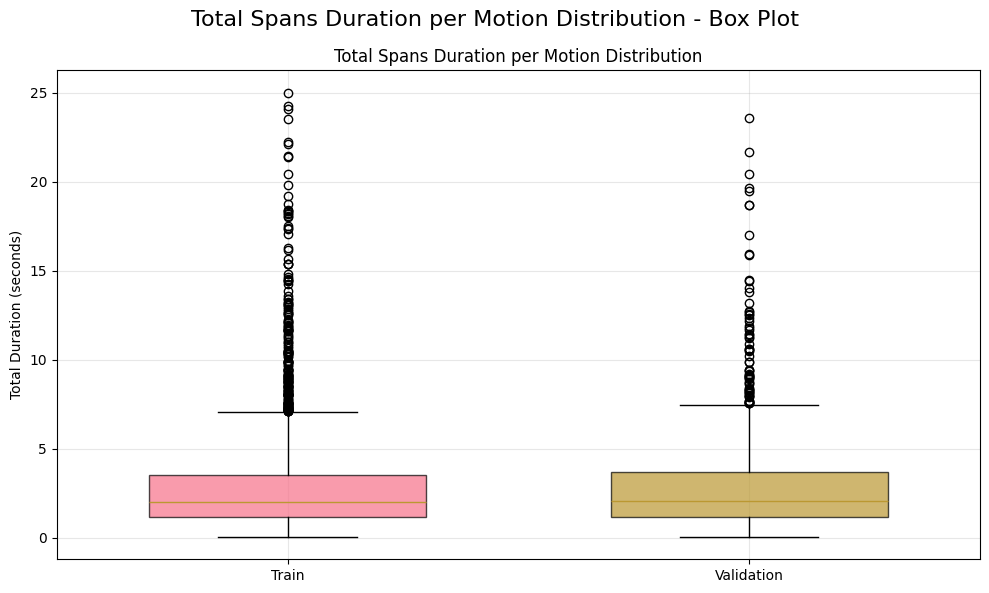

=== TOTAL SPANS DURATION PER MOTION FILTERING ANALYSIS ===

Train Dataset (3296 total motions):
  Motions < 2s total spans: 1621 (49.2%)
  Motions < 3s total spans: 2237 (67.9%)
  Motions < 5s total spans: 2882 (87.4%)
  Motions > 10s total spans: 88 (2.7%)
  Motions > 15s total spans: 29 (0.9%)
  Motions > 20s total spans: 9 (0.3%)
  Motions > 25s total spans: 0 (0.0%)
  Keeping 3s-15s total spans: 1030 motions (31.2% retained)
  Keeping 3s-20s total spans: 1050 motions (31.9% retained)
  Keeping 5s-20s total spans: 405 motions (12.3% retained)
--------------------------------------------------

Validation Dataset (1129 total motions):
  Motions < 2s total spans: 540 (47.8%)
  Motions < 3s total spans: 740 (65.5%)
  Motions < 5s total spans: 970 (85.9%)
  Motions > 10s total spans: 34 (3.0%)
  Motions > 15s total spans: 10 (0.9%)
  Motions > 20s total spans: 3 (0.3%)
  Motions > 25s total spans: 0 (0.0%)
  Keeping 3s-15s total spans: 379 motions (33.6% retained)
  Keeping 3s-20s total

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Total Spans Duration per Motion Distribution - Box Plot', fontsize=16)

datasets = ['Train', 'Validation']
box_data = []
colors = ['C0', 'C1']

for i, analysis in enumerate([train_analysis, validation_analysis]):
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    if spans_durations_per_motion:
        spans_durations_seconds = [d / DEFAULT_FPS for d in spans_durations_per_motion]
        box_data.append(spans_durations_seconds)

bp = ax.boxplot(box_data, positions=[1, 2], widths=0.6, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i])
    box.set_alpha(0.7)

ax.set_title('Total Spans Duration per Motion Distribution')
ax.set_ylabel('Total Duration (seconds)')
ax.set_xticks([1, 2])
ax.set_xticklabels(datasets)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== TOTAL SPANS DURATION PER MOTION FILTERING ANALYSIS ===")
for analysis in [train_analysis, validation_analysis]:
    name = analysis['dataset_name']
    spans_durations_per_motion = analysis['spans_durations_per_motion']
    
    if spans_durations_per_motion:
        total_motions = len(spans_durations_per_motion)
        spans_durations_seconds = [d / DEFAULT_FPS for d in spans_durations_per_motion]
        print(f"\n{name} Dataset ({total_motions} total motions):")
        
        for min_threshold in [2, 3, 5]:
            filtered_min = np.sum(np.array(spans_durations_seconds) < min_threshold)
            print(f"  Motions < {min_threshold}s total spans: {filtered_min} ({filtered_min/total_motions*100:.1f}%)")
            
        for max_threshold in [10, 15, 20, 25]:
            filtered_max = np.sum(np.array(spans_durations_seconds) > max_threshold)
            print(f"  Motions > {max_threshold}s total spans: {filtered_max} ({filtered_max/total_motions*100:.1f}%)")
            
        for min_t, max_t in [(3, 15), (3, 20), (5, 20)]:
            filtered_both = np.sum((np.array(spans_durations_seconds) < min_t) | (np.array(spans_durations_seconds) > max_t))
            remaining = total_motions - filtered_both
            print(f"  Keeping {min_t}s-{max_t}s total spans: {remaining} motions ({remaining/total_motions*100:.1f}% retained)")
    print("-" * 50)